In [173]:
#from loader import Single_SimReader


import re
import os
import matplotlib.pyplot as plt
import logging
import numpy as np
import pandas as pd
import glob
import sqlalchemy as sa
from bin.coadd_analysis_script import load_sql_table
import simulators

from mingle.utilities import parse_paramfile


In [174]:

from simulators.iam_script import target_params, closest_model_params

class Single_SimReader(object):
    def __init__(self, base=".",
                 namebase="BSBHMNOISE",
                 prefix="", mode="bhm", chi2_val="coadd_chi2"):
        self.base = base
        self.namebase = namebase.upper()
        self.prefix = prefix.upper()
        if mode in ["iam", "tcm", "bhm"]:
            self.mode = mode
        else:
            raise ValueError("Invalid SimReader mode")
        if chi2_val in ["chi2_1", "chi2_2", "chi2_3", "chi2_4", "coadd_chi2"]:
            self.chi2_val = chi2_val
        else:
            raise ValueError("Invalid chi2_val.")
    
    def list_sims(self):
        return glob.glob(os.path.join(self.base, "*"))
    
    def load_df(self, params=["teff_1", "teff_2", "logg_1", "feh_1"]):
        params.append(self.chi2_val)
      
        table = self.get_table()
        print(table.c)
        params = [table.c[p] for p in params]
        dbdf = pd.read_sql(sa.select(params).order_by(table.c[self.chi2_val].asc()), table.metadata.bind)
                
        # Coerce to be numeric columns
        c = dbdf.columns[dbdf.dtypes.eq(object)]
        dbdf[c] = dbdf[c].apply(pd.to_numeric, errors='coerce', axis=0)
        return dbdf
    
    def get_table(self):
        starname = self.namebase
        directory = os.path.join(self.base, starname, self.mode)
        print(directory)
        dbs = glob.glob(os.path.join(directory, "*_coadd_{}_chisqr_results.db".format(self.mode)))
        print(dbs)
        assert len(dbs) == 1, print(len(dbs))
        dbname = dbs[0]
        table = load_sql_table(dbname, verbose=False, echo=False)
        return table       
     
    def params(self):
        """Get params from param file."""
        if simulators.paths["parameters"].startswith(".")
            param_file = os.path.join(self.base , "../", simulators.paths["parameters"], "{}_params.dat".format(self.namebase))
        elif:
            param_file = os.path.join(simulators.paths["parameters"], "{}_params.dat".format(self.namebase))
        params = parse_paramfile(param_file, path=None)
        print(params)
        print("self mode", self.mode)
        if self.mode == "bhm":
            host_params = target_params(params, mode=self.mode)
            closest_host_model = closest_model_params(*host_params)  # unpack temp, logg, fe_h with *
            closest_comp_model = {}
        else:
            host_params, comp_params = target_params(params, mode=self.mode)
            closest_host_model = closest_model_params(*host_params)  # unpack temp, logg, fe_h with *
            closest_comp_model = closest_model_params(*comp_params)
            params.update({"teff_2": closest_comp_model[0], "logg_2":closest_comp_model[1], "feh_2":closest_comp_model[2]})
        
        params.update({"teff_1": closest_host_model[0], "logg_1":closest_host_model[1], "feh_1":closest_host_model[2] })
        return params

SyntaxError: invalid syntax (<ipython-input-174-3b7de6fc4aa0>, line 49)

In [ ]:
chi2_names = ["chi2_1", "chi2_2", "chi2_3", "chi2_4", "coadd_chi2"]
npix_names = ["npix_1", "npix_2", "npix_3", "npix_4", "coadd_npix"]

  
def dataframe_contour(df, xcol, ycol, zcol, params):
    import logging
    x = sorted(np.array(list(set(df[xcol].values))))
    y = sorted(np.array(list(set(df[ycol].values))))

    # Create grid for chi2 values
    z_grid = np.empty((len(x), len(y)))
    for i, x_value in enumerate(x):
        for j, y_value in enumerate(y):
            try:
                z_grid[i, j] = df.loc[(df[xcol].values == x_value) * (df[ycol].values == y_value), zcol].values
            except ValueError as e:
                print("x_S * y_s", sum((df[xcol].values == x_value) * (df[ycol].values == y_value)))
                print("Check metallicity and logg of companion")
                raise e

    x_grid, y_grid = np.meshgrid(x, y, indexing='ij')

    assert x_grid.shape == z_grid.shape
    assert x_grid.shape == y_grid.shape

    try:
        fig, ax = plt.subplots()
        c = ax.contourf(x_grid, y_grid, z_grid, alpha=0.5, cmap=plt.cm.inferno)
        # Mark minimum with a +.
        min_i, min_j = divmod(z_grid.argmin(), z_grid.shape[1])
        plt.plot(x_grid[i], y_grid[j], "r+", markersize=5)
        cbar = plt.colorbar(c)
        cbar.ax.set_ylabel(zcol)
        ax.set_xlabel(r"$ {0}$".format(xcol), fontsize=15)
        ax.set_ylabel(r"$ {0}$".format(ycol), fontsize=15)
        ax.set_title(
            '{0}: {1} contour, at min chi2 {2} value, dof={3}-{4}'.format(params["star"], zcol, params["par_limit"],
                                                                          params["this_npix"], params["npars"]))
        ax.grid(True)
        fig.tight_layout()
        name = "{0}-{1}_{2}_{3}_{4}_{5}_contour_{6}.pdf".format(
            params["star"], params["obsnum"], params["chip"], xcol, ycol, zcol, params["suffix"])
        plt.savefig(os.path.join(params["path"], "plots", name))
        plt.savefig(os.path.join(params["path"], "plots", name.replace(".pdf", ".png")))
        plt.close()
    except Exception as e:
        logging.warning(__("database_contour did not plot due to \n{0}", e))


In [175]:
EX1500bhm = Single_SimReader(base="/home/jneal/Phd/Analysis/Paper_examples/Example1-500/analysis",
                          namebase="Example1500", mode="bhm")
df = EX1500bhm.load_df(["teff_1", "gamma"])

df.head()

/home/jneal/Phd/Analysis/Paper_examples/Example1-500/analysis/EXAMPLE1500/bhm
['/home/jneal/Phd/Analysis/Paper_examples/Example1-500/analysis/EXAMPLE1500/bhm/EXAMPLE1500-1_coadd_bhm_chisqr_results.db']
['chi2_table.index', 'chi2_table.teff_1', 'chi2_table.logg_1', 'chi2_table.feh_1', 'chi2_table.gamma', 'chi2_table.npix_1', 'chi2_table.chi2_1', 'chi2_table.arbnorm_1', 'chi2_table.xcorr_1', 'chi2_table.npix_2', 'chi2_table.chi2_2', 'chi2_table.arbnorm_2', 'chi2_table.xcorr_2', 'chi2_table.npix_3', 'chi2_table.chi2_3', 'chi2_table.arbnorm_3', 'chi2_table.xcorr_3', 'chi2_table.npix_4', 'chi2_table.chi2_4', 'chi2_table.arbnorm_4', 'chi2_table.xcorr_4', 'chi2_table.coadd_chi2', 'chi2_table.coadd_npix']


,teff_1,gamma,coadd_chi2
0,5200,0.0,0.035934
1,5100,0.0,0.047731
2,5200,0.5,0.053530
3,5200,-0.5,0.057935
4,5100,0.5,0.065758


In [176]:
EX1500bhm.params()

WARNING Logg for companion 'comp_logg' is not set for {'star': 'example1500', 'temp': 5200.0, 'logg': 4.5, 'fe_h': 0.0}


{'star': 'example1500', 'temp': 5200.0, 'logg': 4.5, 'fe_h': 0.0}
self mode bhm
mode in target params bhm


{'fe_h': 0.0,
 'feh_1': 0.0,
 'logg': 4.5,
 'logg_1': 4.5,
 'star': 'example1500',
 'teff_1': 5200,
 'temp': 5200.0}

In [177]:
table = EX1500bhm.get_table()
df = 

SyntaxError: invalid syntax (<ipython-input-177-05082d03b76d>, line 2)

In [178]:
df=df.pivot('teff_1', 'gamma', 'coadd_chi2')

X=df.columns.values
Y=df.index.values
Z=df.values
x,y=np.meshgrid(X, Y)
plt.contourf(x, y, Z)  # the NAN will be plotted as white spaces


ValueError: Index contains duplicate entries, cannot reshape

In [179]:
table = EX1500bhm.get_table()

/home/jneal/Phd/Analysis/Paper_examples/Example1-500/analysis/EXAMPLE1500/bhm
['/home/jneal/Phd/Analysis/Paper_examples/Example1-500/analysis/EXAMPLE1500/bhm/EXAMPLE1500-1_coadd_bhm_chisqr_results.db']


In [180]:
from sqlalchemy import and_

from mingle.utilities.db_utils import DBExtractor
        

In [181]:
tab = DBExtractor(table)

In [182]:
df = tab.simple_extraction(["teff_1", "gamma"])
df = tab.fixed_extraction(["teff_1", "gamma"], {"teff_1": 5200, "gamma":0})
print(len(df))
df.head()

8


,teff_1,gamma
0,5200,0.0
1,5200,0.0
2,5200,0.0
3,5200,0.0
4,5200,0.0


In [183]:
# Manual database extraction to get it done quickly
# Finish by 11am
df = tab.full_extraction()

df.head()


/home/jneal/Phd/Codes/companion_simulations/mingle/utilities/db_utils.py:59: UserWarning: Loading in a database may cause memory cap issues.
  warnings.warn("Loading in a database may cause memory cap issues.")


,index,teff_1,logg_1,feh_1,gamma,npix_1,chi2_1,arbnorm_1,xcorr_1,npix_2,...,npix_3,chi2_3,arbnorm_3,xcorr_3,npix_4,chi2_4,arbnorm_4,xcorr_4,coadd_chi2,coadd_npix
0,1,4800,2.5,0.0,-10.0,1024,2.639881,1.01,8.526513e-13,1024,...,1024,0.749647,1.01,8.526513e-13,972,0.730416,1.0,8.526513e-13,5.785828,4044
1,2,4800,2.5,0.0,-9.5,1024,2.536063,1.01,8.526513e-13,1024,...,1024,0.727542,1.01,8.526513e-13,972,0.716118,1.0,8.526513e-13,5.576244,4044
2,3,4800,2.5,0.0,-9.0,1024,2.447096,1.01,8.526513e-13,1024,...,1024,0.710449,1.01,8.526513e-13,972,0.706721,1.0,8.526513e-13,5.401861,4044
3,4,4800,2.5,0.0,-8.5,1024,2.334578,1.01,8.526513e-13,1024,...,1024,0.685123,1.01,8.526513e-13,972,0.693870,1.0,8.526513e-13,5.177800,4044
4,5,4800,2.5,0.0,-8.0,1024,2.220701,1.01,8.526513e-13,1024,...,1024,0.658402,1.01,8.526513e-13,972,0.678755,1.0,8.526513e-13,4.947934,4044


In [29]:
min_chi2 = min(df["coadd_chi2"])
df_min = df[df["coadd_chi2"]== min_chi2]
            
df_min.head()

,index,teff_1,logg_1,feh_1,gamma,npix_1,chi2_1,arbnorm_1,xcorr_1,npix_2,...,npix_3,chi2_3,arbnorm_3,xcorr_3,npix_4,chi2_4,arbnorm_4,xcorr_4,coadd_chi2,coadd_npix
920,921,5200,4.5,0.0,0.0,1024,0.007391,1.0,8.526513e-13,1024,...,1024,0.007263,1.0,8.526513e-13,972,0.01391,1.0,8.526513e-13,0.035934,4044


In [32]:
# Limit to this logg and feh 
min_gamma = df_min["gamma"]
min_logg_1 = df_min["logg_1"]
min_feh_1 = df_min["feh_1"]

df_lim = df.copy()
for param in ["logg_1", "feh_1"]:
    #print(len(df_min[param].values[0]))
    df_lim = df_lim[df_lim[param] == df_min[param].values[0]]
    print(df_lim.shape)


(270, 23)
(270, 23)


In [33]:
df2 = df_lim[["teff_1", "gamma", "coadd_chi2"]]
df2 = df2.sort_values("teff_1")
df3 = df2[df2["gamma"] == df_min["gamma"].values[0]]

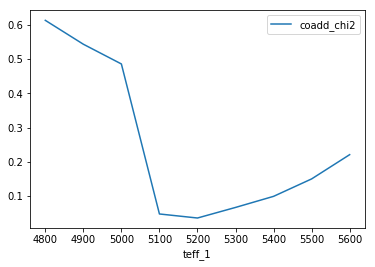

In [34]:
df3.plot("teff_1", "coadd_chi2")

In [35]:
df4 = df2.pivot("teff_1", "gamma", "coadd_chi2")
df4.head()

gamma,-10.0,-9.5,-9.0,-8.5,-8.0,-7.5,-7.0,-6.5,-6.0,-5.5,...,0.0,0.5,1.0,1.5,2.0,2.5,3.0,3.5,4.0,4.5
teff_1,,,,,,,,,,,,,,,,,,,,,
4800,3.772263,3.611158,3.461610,3.290390,3.116812,2.936113,2.740970,2.551584,2.337025,2.147114,...,0.613310,0.627859,0.676863,0.755045,0.862361,0.997039,1.151644,1.328735,1.512712,1.720040
4900,3.661128,3.502305,3.354969,3.186914,3.015336,2.836827,2.644636,2.457411,2.246201,2.057828,...,0.543548,0.557071,0.604838,0.681853,0.786704,0.917899,1.069959,1.244021,1.423827,1.627933
5000,3.585298,3.429990,3.285754,3.120574,2.952056,2.776458,2.585831,2.401329,2.191925,2.004619,...,0.485882,0.501744,0.549923,0.626686,0.732461,0.864869,1.016144,1.189464,1.368435,1.570740
5100,3.575434,3.416663,3.272037,3.100548,2.923407,2.736838,2.526887,2.325411,2.087424,1.875928,...,0.047731,0.065758,0.125522,0.221274,0.352897,0.514962,0.701317,0.912772,1.130494,1.373733
5200,3.485584,3.331738,3.191904,3.025278,2.853127,2.671663,2.467053,2.270408,2.038165,1.831006,...,0.035934,0.053530,0.110961,0.204216,0.332963,0.490865,0.672588,0.878924,1.091118,1.328181


In [36]:
X=df4.columns.values
Y=df4.index.values
Z=df4.values
print(X, Y, Z.shape)

[-10.   -9.5  -9.   -8.5  -8.   -7.5  -7.   -6.5  -6.   -5.5  -5.   -4.5
  -4.   -3.5  -3.   -2.5  -2.   -1.5  -1.   -0.5   0.    0.5   1.    1.5
   2.    2.5   3.    3.5   4.    4.5] [4800 4900 5000 5100 5200 5300 5400 5500 5600] (9, 30)


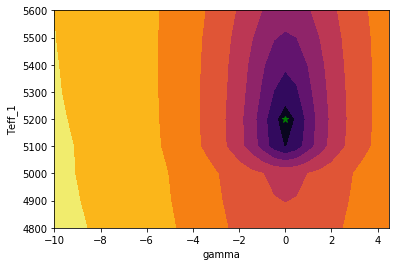

In [37]:
x,y=np.meshgrid(X, Y, indexing="xy")
plt.contourf(x, y, np.log(Z)) 
plt.xlabel("gamma")
plt.ylabel("Teff_1")
# 
# Mark minimum with a +.
min_i, min_j = divmod(Z.argmin(), Z.shape[1])
plt.plot(X[min_j], Y[min_i], "g*", markersize=7)

NameError: name 'logging' is not defined

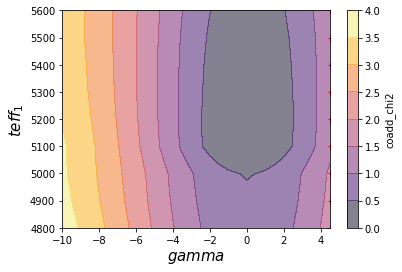

In [107]:
dataframe_contour(df2, "gamma", "teff_1", "coadd_chi2", [])

In [130]:
def df_contour(df, xcol, ycol, zcol, df_min, lim_params, correct=None):
    
    df_lim = df.copy()
    for param in lim_params:
        df_lim = df_lim[df_lim[param] == df_min[param].values[0]]

    dfpivot = df_lim.pivot(xcol, ycol, zcol)

    Y = dfpivot.columns.values
    X = dfpivot.index.values
    Z = dfpivot.values
    print(X, Y, Z.shape)

    x, y = np.meshgrid(X, Y, indexing="ij")
    
    fig, ax = plt.subplots()
    c = ax.contourf(x, y, np.log(Z)) 
    cbar = plt.colorbar(c)
    cbar.ax.set_ylabel(zcol)
    plt.xlabel(xcol)
    plt.ylabel(ycol)
    
    if correct:
        # Correct location of simulation
        plt.plot(correct[xcol], correct[ycol], "ro", markersize=7)

    # Mark minimum with a +.
    min_i, min_j = divmod(Z.argmin(), Z.shape[1])
    plt.plot(X[min_i], Y[min_j], "g*", markersize=7, label="$Min \chi^2$")
    
    


# Manual Trying binary

In [169]:

EX1500iam = Single_SimReader(base="/home/jneal/Phd/Analysis/Paper_examples/Example1-500/analysis",
                          namebase="Example1500", mode="iam")

table_iam = EX1500iam.get_table()
tab_iam = DBExtractor(table_iam)

df_min = tab_iam.minimum_value_of("coadd_chi2")
df_min.head()

exp1500 = []

/home/jneal/Phd/Analysis/Paper_examples/Example1-500/analysis/EXAMPLE1500/iam
['/home/jneal/Phd/Analysis/Paper_examples/Example1-500/analysis/EXAMPLE1500/iam/EXAMPLE1500-1_coadd_iam_chisqr_results.db']


In [132]:

cols = ['teff_2', 'logg_2', 'feh_2', 'rv', 'gamma', "chi2_1",
        'coadd_chi2', 'teff_1','logg_1', 'feh_1']


fixed = {key: df_min[key].values[0] for key in ["logg_1", "logg_2", "feh_1", "feh_2"]}
print(fixed)
df = tab_iam.fixed_extraction(cols, fixed, limit=-1)
print(df.shape)
df.head()


{'logg_1': 2.5, 'logg_2': 3.0, 'feh_1': 0.0, 'feh_2': 0.0}
(1200, 10)


,teff_2,logg_2,feh_2,rv,gamma,chi2_1,coadd_chi2,teff_1,logg_1,feh_1
0,2400,3.0,0.0,-10.0,-10.0,475631.8010,1.394019e+06,4800.0,2.5,0.0
1,2400,3.0,0.0,-10.0,-9.5,457156.9268,1.348116e+06,4800.0,2.5,0.0
2,2400,3.0,0.0,-10.0,-9.0,440821.3445,1.308486e+06,4800.0,2.5,0.0
3,2400,3.0,0.0,-10.0,-8.5,420665.1864,1.257272e+06,4800.0,2.5,0.0
4,2400,3.0,0.0,-10.0,-8.0,399942.0090,1.204378e+06,4800.0,2.5,0.0


[ 4800.] [ 0.] (1, 1)


TypeError: Input z must be at least a 2x2 array.

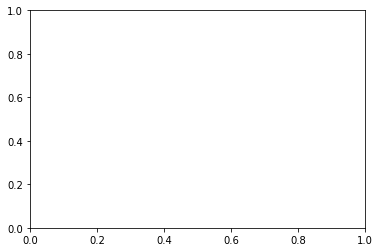

In [133]:
# teff_1 - teff_2 contour
df_contour(df, "teff_1", "gamma", "chi2_1", df_min, ["gamma", "rv"])

[-10.   -9.5  -9.   -8.5  -8.   -7.5  -7.   -6.5  -6.   -5.5  -5.   -4.5
  -4.   -3.5  -3.   -2.5  -2.   -1.5  -1.   -0.5   0.    0.5   1.    1.5
   2.    2.5   3.    3.5   4.    4.5] [ 4800.] (30, 1)


TypeError: Input z must be at least a 2x2 array.

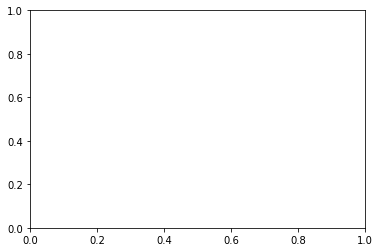

In [134]:
# teff_1 - gamma contour
df_contour(df, "gamma", "teff_1", "coadd_chi2", df_min, ["teff_2", "rv"], correct={"gamma":-15, "teff_1":6200})

In [137]:
# rv - gamma contour

[-10.   -9.5  -9.   -8.5  -8.   -7.5  -7.   -6.5  -6.   -5.5  -5.   -4.5
  -4.   -3.5  -3.   -2.5  -2.   -1.5  -1.   -0.5   0.    0.5   1.    1.5
   2.    2.5   3.    3.5   4.    4.5   5.    5.5   6.    6.5   7.    7.5
   8.    8.5   9.    9.5] [-10.   -9.5  -9.   -8.5  -8.   -7.5  -7.   -6.5  -6.   -5.5  -5.   -4.5
  -4.   -3.5  -3.   -2.5  -2.   -1.5  -1.   -0.5   0.    0.5   1.    1.5
   2.    2.5   3.    3.5   4.    4.5] (40, 30)


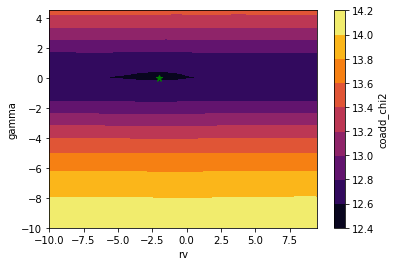

In [138]:
df_contour(df, "rv", "gamma", "coadd_chi2", df_min, ["teff_1", "teff_2"])

[-10.   -9.5  -9.   -8.5  -8.   -7.5  -7.   -6.5  -6.   -5.5  -5.   -4.5
  -4.   -3.5  -3.   -2.5  -2.   -1.5  -1.   -0.5   0.    0.5   1.    1.5
   2.    2.5   3.    3.5   4.    4.5   5.    5.5   6.    6.5   7.    7.5
   8.    8.5   9.    9.5] [2400] (40, 1)


TypeError: Input z must be at least a 2x2 array.

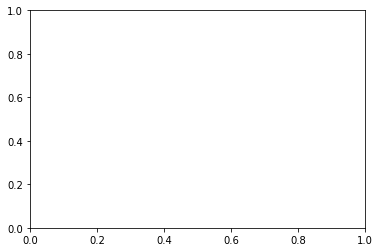

In [141]:
# teff_2 - rv
df_contour(df, "rv", "teff_2", "coadd_chi2", df_min, ["teff_1", "gamma"])


In [170]:
table=table_iam
extractor= DBExtractor(table)
chi2_val = "coadd_chi2"
df = extractor.minimum_value_of(chi2_val)


df2 = pd.read_sql_query(sa.select([table.c.teff_1, table.c.logg_1, table.c.feh_1,
                                          table.c.teff_2, table.c.logg_2, table.c.feh_2,
                                          table.c.gamma, table.c.rv,
                                          table.c.alpha_1, table.c.alpha_2, table.c.alpha_3, table.c.alpha_4,
                                          table.c[chi2_val]]).order_by(table.c[chi2_val].asc()).limit(1),
                               table.metadata.bind)

In [171]:
df.head()


,index,teff_2,logg_2,feh_2,alpha_1,npix_1,rv,gamma,chi2_1,arbnorm_1,...,arbnorm_3,alpha_4,npix_4,chi2_4,arbnorm_4,coadd_chi2,coadd_npix,teff_1,logg_1,feh_1
0,501,2400,3.0,0.0,0.0139,1024,-2.0,0.0,55543.2336,1.0,...,1.01,0.0148,972,155559.8943,0.99,294247.2191,4044,4800.0,2.5,0.0


In [172]:
df2.head()

,teff_1,logg_1,feh_1,teff_2,logg_2,feh_2,gamma,rv,alpha_1,alpha_2,alpha_3,alpha_4,coadd_chi2
0,4800.0,2.5,0.0,2400,3.0,0.0,0.0,-2.0,0.0139,0.0141,0.0146,0.0148,294247.2191
